In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

import sys, importlib
from FetchModel import FetchModel
from PostPred import PostPred
importlib.reload(sys.modules['FetchModel'])
importlib.reload(sys.modules['PostPred'])
from FetchModel import FetchModel
from PostPred import PostPred

In [2]:
Y = pd.read_csv("../Datasets/Dataset_180.csv")
Y['Count_180'] = pd.to_numeric(Y['Count_180']).astype('Int64')
X = pd.read_csv("../Datasets/variables_to_select.csv")
X_raw = pd.read_csv("../Datasets/covariates.csv")

In [3]:
idx_obs = Y[Y['Count_180'].notna()].index
idx_miss = Y[Y['Count_180'].isna()].index

Y_obs = Y.loc[idx_obs, :].reset_index(drop=True)
Y_miss = Y.loc[idx_miss, :].reset_index(drop=True)

X_obs = X.loc[idx_obs, :].reset_index(drop=True)
X_miss = X.loc[idx_miss, :].reset_index(drop=True)

In [4]:
stations = Y['idSensore']
years = pd.Series(Y['Year'] - 2009)
months = pd.Series(Y['Month'] - 3)
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = pd.Series(stations)
stations = pd.Series(transformed_stations)

stations_obs = stations.loc[idx_obs].reset_index(drop=True)
stations_miss = stations.loc[idx_miss].reset_index(drop=True)
years_obs = years.loc[idx_obs].reset_index(drop=True)
years_miss = years.loc[idx_miss].reset_index(drop=True)
months_obs = months.loc[idx_obs].reset_index(drop=True)
months_miss = months.loc[idx_miss].reset_index(drop=True)


day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month = [day_in_month[Y['Month'][i]-1] for i in range(0,Y.shape[0]) ]

max_month = pd.Series(max_month)
max_month_obs = max_month.loc[idx_obs].reset_index(drop=True)
max_month_miss = max_month.loc[idx_miss].reset_index(drop=True)

In [5]:
phi = 63
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [6]:
model_zip = FetchModel("zip").compile()

17:20:18 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\zip.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\zip.exe


17:23:56 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\zip.exe


In [7]:
data_zip = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations_obs,
    "year": years_obs,
    "y": Y_obs['Count_180'],
    "X": X_obs,
    "phi" : phi,
    "distances" : distances,
    "nmonths" : 7,
    "month" : months_obs
}

fit_zip = model_zip.sample(data=data_zip, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_180_zip = az.from_cmdstanpy(fit_zip)

17:23:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:37:18 - cmdstanpy - INFO - CmdStan done processing.
17:37:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = nan, but A[2,1] = nan (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/zip.stan', line 43, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = nan, but A[2,1] = nan (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/zip.stan', line 43, column 2 to column 63)
Exception: cholesky_decompose: Matrix m is not positive definite (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/zip.stan', line 43, column 2 to column 63)
Exception: cholesky_decompose: Matrix m is not positive definite (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/zip.stan', line 43, column 2 to column 63)
Exception: cholesky_decompose: Matrix m is not positive definite (in 'C:/Users/matte/Desktop/Bayesian_St

In [15]:
post_pred = PostPred(posterior_180_zip, Y['Count_180'])
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

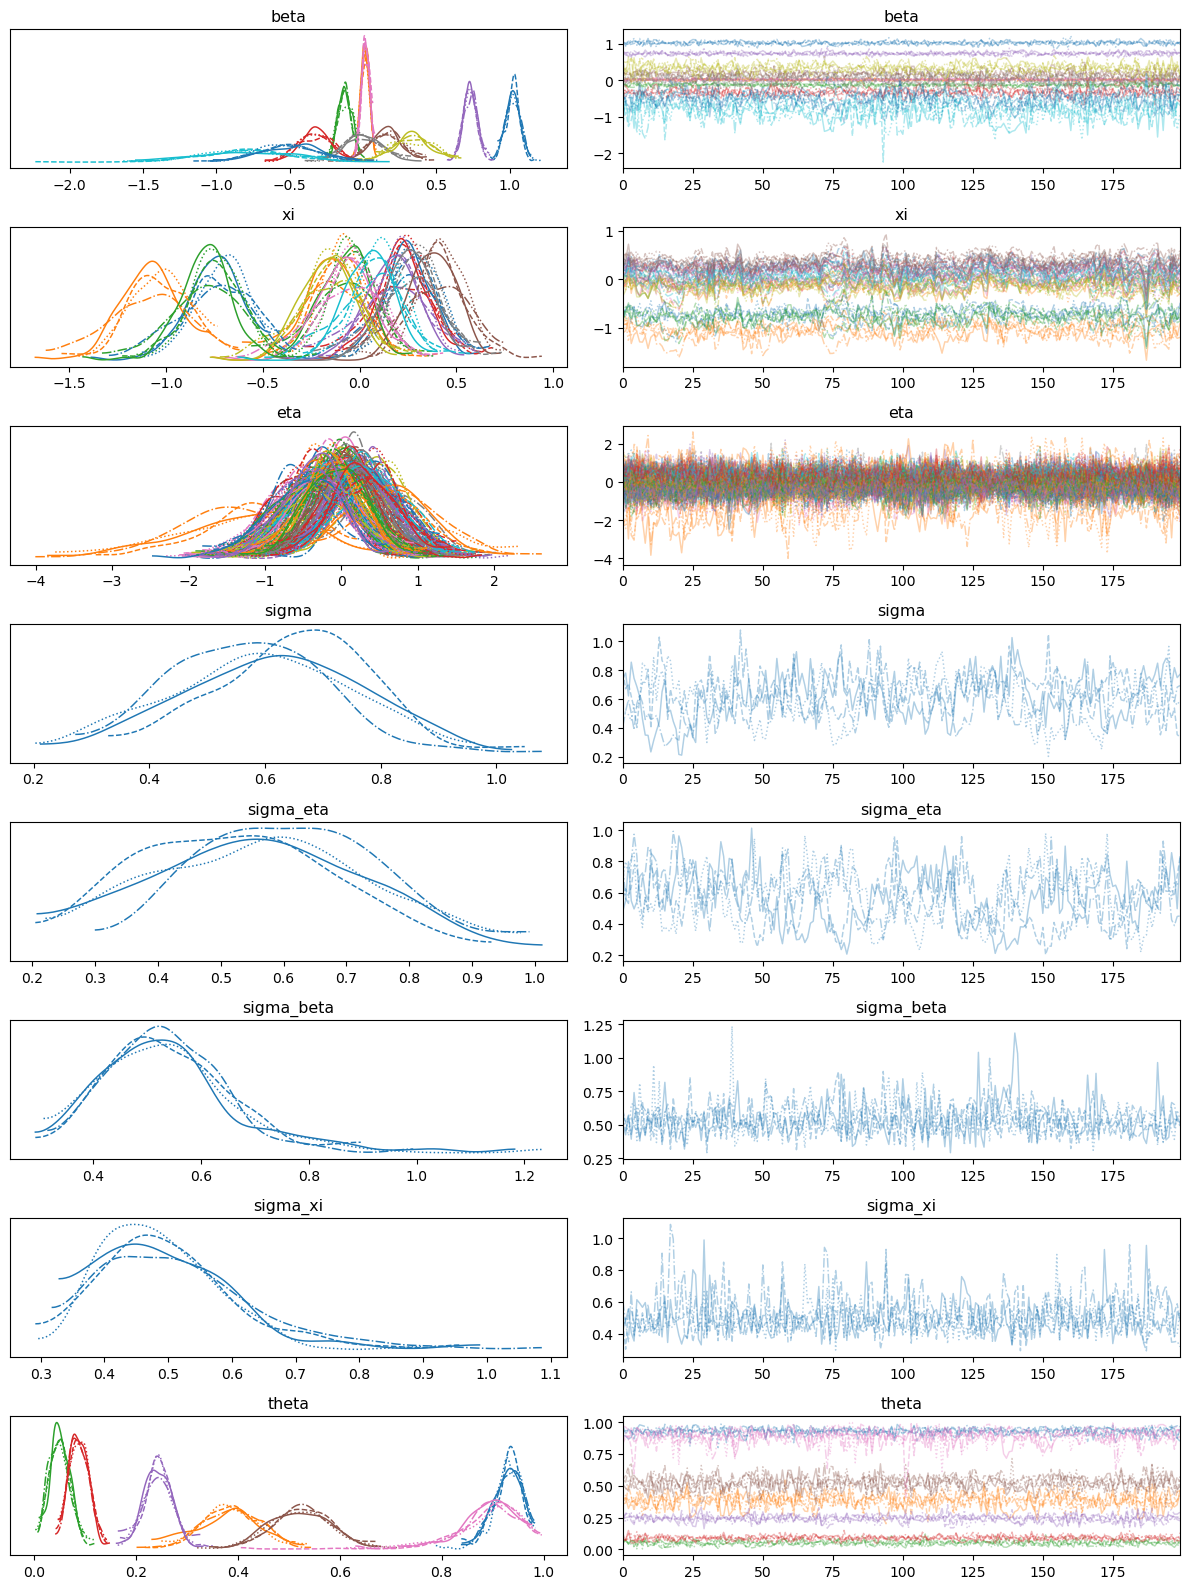

In [16]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma', 'sigma_eta', 'sigma_beta', 'sigma_xi', 'theta'])
plt.tight_layout()
plt.show()

In [17]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -3713.27    78.43
p_waic       99.64        -

There has been a warning during the calculation. Please check the results.
Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -3714.11    78.46
p_loo      100.47        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3802   99.8%
 (0.5, 0.7]   (ok)          6    0.2%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [53]:
y_pred, metrics = post_pred.predict(error_metrics=True)

In [54]:
alpha = 0.05
theta_med = post_pred.posterior_med.theta.values
alpha_adj = (alpha+theta_med-alpha*theta_med)
quantiles_per_month = [post_pred.posterior.y_pred.quantile([alpha_adj[i]/2, 1-alpha_adj[i]/2], dim=['chain', 'draw']).values for i in range(0, len(alpha_adj))]
y_CI = [quantiles_per_month[months_obs[i]-1][:, i] for i in range(0, len(months_obs))]
y_star_up = [y_CI[i][1] for i in range(0, len(y_CI))]
y_star_low = [y_CI[i][0] for i in range(0, len(y_CI))]
y_star_up = pd.Series(y_star_up)
y_star_low = pd.Series(y_star_low)

In [55]:
outliers = np.where(((Y_obs['Count_180'] > y_star_up) | (Y_obs['Count_180'] < y_star_low)) & Y_obs['Count_180'] != 0)[0]
percentage_inside = 1 - len(outliers)/len(Y_obs)

In [56]:
y_obs, residuals, mse, mae, mad = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[  26   74   78   85  100  144  150  160  166  173  176  187  233  250
  280  284  287  293  346  347  372  378  384  385  402  403  426  441
  474  475  529  579  595  596  602  609  630  644  656  657  658  675
  676  677  698  699  729  798  800  851  859  867  869  872  873 1014
 1035 1036 1043 1093 1094 1114 1122 1135 1150 1156 1157 1183 1215 1262
 1279 1337 1366 1380 1388 1448 1477 1490 1491 1539 1540 1560 1568 1580
 1582 1602 1618 1619 1647 1658 1702 1707 1748 1791 1807 1813 1832 1878
 1879 1886 1928 1935 1973 1983 2019 2092 2095 2103 2110 2117 2124 2127
 2131 2135 2139 2143 2154 2174 2188 2224 2240 2314 2331 2338 2341 2344
 2350 2363 2371 2389 2440 2445 2449 2458 2492 2518 2532 2551 2561 2562
 2563 2569 2575 2576 2630 2646 2649 2650 2672 2673 2680 2683 2705 2714
 2737 2750 2755 2769 2772 2825 2851 2854 2857 2865 2877 2879 2920 2940
 2953 2954 2961 2987 2997 2998 3001 3030 3044 3079 3087 3100 3160 3167
 3185 3220 3222 3226 3227 3272 3313 3324 3329 3330 3335 3336 3356 3

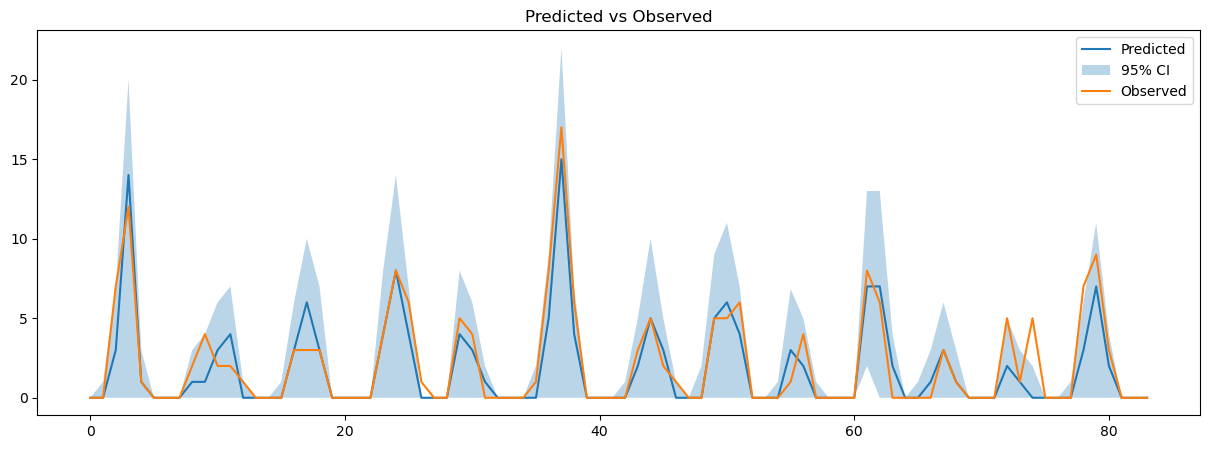

In [57]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label='95% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()